In [15]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import re
import os
import seaborn
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
%matplotlib inline



In [16]:
#download the model to local so it can be used again and again
!mkdir -p module/module_elmo2
# Download the module, and uncompress it to the destination folder. 
!curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC module/module_elmo2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
x assets/
x saved_model.pb
x tfhub_module.pb
x variables/
x variables/variables.index
100  331M  100  331M    0     0  2076k      0  0:02:43  0:02:43 --:--:-- 1823kk      0  0:01:04  0:00:11  0:00:53 4845k89k      0  0:02:16  0:00:59  0:01:17 1847k56M    0     0  2419k      0  0:02:20  0:01:06  0:01:14 1833k0     0  2261k      0  0:02:29  0:01:31  0:00:58 1836k2135k      0  0:02:38  0:02:10  0:00:28 1989k



In [17]:
# run elmo embeddings from scratch

elmo = hub.Module("module/module_elmo2/", trainable=True)
sentence_input = ["the cat is on the mat", "what are you doing in evening"]

word_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["word_emb"]

lstm1_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["lstm_outputs1"]

lstm2_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["lstm_outputs2"]

elmo_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["elmo"]

default_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["default"]


print(word_embeddings)
print(lstm1_embeddings)
print(lstm2_embeddings)
print(elmo_embeddings)
print(default_embeddings)


Tensor("module_1_apply_default/bilm/Reshape_1:0", shape=(2, 6, 512), dtype=float32)
Tensor("module_1_apply_default_1/concat:0", shape=(2, ?, 1024), dtype=float32)
Tensor("module_1_apply_default_2/concat_1:0", shape=(2, ?, 1024), dtype=float32)
Tensor("module_1_apply_default_3/aggregation/mul_3:0", shape=(2, 6, 1024), dtype=float32)
Tensor("module_1_apply_default_4/truediv:0", shape=(2, 1024), dtype=float32)


In [8]:
# assign elmo module to "elmo" variable

elmo = hub.Module("module/module_elmo2/", trainable=True)
sentence_input = ["the cat is on the mat", "what are you doing in evening"]

# create an "embeddings" tensor for two sample sentences using the elmo module
embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["elmo"]

embeddings



UnsupportedHandleError: unsupported handle format 'module/module_elmo2/'. No resolvers found that can successfully resolve it. If the handle points to the local filesystem, the error indicates that the module directory does not exist. Supported handle formats: URLs pointing to a TGZ  file (e.g. https://address/module.tgz), or Local File System directory file (e.g. /tmp/my_local_module).

In [4]:
# run a session using the "elmo_embeddings" tensor to create the ELMO embeddings and save in variable "message_embeddings"

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embeddings)

# print type and length of the embeddings

print(type(message_embeddings))
print(len(message_embeddings))

# print the first embeddings for the first sentence, print type and length
print(message_embeddings[0])
print(type(message_embeddings[0]))
print(len(message_embeddings[0]))

# print each of the six embeddings for the first sentence
print(message_embeddings[0][0])
print(type(message_embeddings[0][0]))
print(len(message_embeddings[0][0]))

print(message_embeddings[0][1])
print(message_embeddings[0][2])
print(message_embeddings[0][3])
print(message_embeddings[0][4])
print(message_embeddings[0][5])

# print the scalar value of the 1024th dimension of the 6th embedding of the second sentence
print(message_embeddings[1][5][1023])


<class 'numpy.ndarray'>
2
[[ 0.30815452  0.26630372  0.235613   ... -0.37085718  0.16490507
  -0.07245942]
 [ 0.51428753 -0.13532326  0.11090407 ...  0.04046863 -0.0478974
   0.7365962 ]
 [-0.02588051 -0.07283653 -0.079356   ... -0.29072428  0.72421414
   0.43863517]
 [-0.34798035 -0.02910249 -0.81993073 ... -0.9204842   0.02188802
   0.12106002]
 [-0.21827465 -0.13076591 -0.25209627 ... -0.29693586 -0.15828016
  -0.04900745]
 [ 0.10072576 -0.02953491 -0.24494296 ... -0.3723504  -0.14875814
   0.21592234]]
<class 'numpy.ndarray'>
6
[ 0.30815452  0.26630372  0.235613   ... -0.37085718  0.16490507
 -0.07245942]
<class 'numpy.ndarray'>
1024
[ 0.51428753 -0.13532326  0.11090407 ...  0.04046863 -0.0478974
  0.7365962 ]
[-0.02588051 -0.07283653 -0.079356   ... -0.29072428  0.72421414
  0.43863517]
[-0.34798035 -0.02910249 -0.81993073 ... -0.9204842   0.02188802
  0.12106002]
[-0.21827465 -0.13076591 -0.25209627 ... -0.29693586 -0.15828016
 -0.04900745]
[ 0.10072576 -0.02953491 -0.24494296 ..

In [11]:
# load a subset of the FNC dataset

data = pd.read_csv("w210_FakeNews-master/data/FNC_Subset.csv")
data.head()


,Unnamed: 0,Unnamed: 0.1,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,0,0,2,express.co.uk,rumor,https://www.express.co.uk/news/science/738402/...,"Life is an illusion, at least on a quantum lev...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Is life an ILLUSION? Researchers prove 'realit...,Sean Martin,NaN,[''],THE UNIVERSE ceases to exist when we are not l...,NaN,NaN,NaN
1,1,1,6,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,"Unfortunately, he hasn’t yet attacked her for ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
2,2,2,7,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,The Los Angeles Police Department has been den...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
3,3,3,8,barenakedislam.com,hate,http://barenakedislam.com/2017/12/24/more-winn...,The White House has decided to quietly withdra...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"MORE WINNING! Israeli intelligence source, DEB...","Cleavis Nowell, Cleavisnowell, Clarence J. Fei...",NaN,[''],NaN,NaN,NaN,NaN
4,4,4,9,barenakedislam.com,hate,http://barenakedislam.com/2017/12/25/oh-trump-...,“The time has come to cut off the tongues of t...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"“Oh, Trump, you coward, you just wait, we will...","F.N. Lehner, Don Spilman, Clarence J. Feinour,...",NaN,[''],NaN,NaN,NaN,NaN


In [12]:
# create embeddings for one of the sentences from the FNC dataset

embeddings = elmo(
["Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers."],
signature="default",
as_dict=True)["elmo"]

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    LifeIllusion = session.run(embeddings)
    
print(LifeIllusion)
print(LifeIllusion.shape)


[[[-0.0870266  -0.27838877 -0.3471388  ...  0.17157874  0.42688212
   -0.0403038 ]
  [ 0.08745959 -0.01249966 -0.11062857 ... -0.2706779   0.8397048
    0.4150948 ]
  [-0.35278875  0.32002047  0.05191879 ... -0.0023558   0.03955639
    0.17205797]
  ...
  [-0.21938455 -0.6128549   0.3982283  ...  0.1737078   0.1487723
    0.1408177 ]
  [ 0.29800346  0.5621023  -0.18698221 ... -1.0533533   0.32813936
   -0.12598152]
  [-0.62032086  0.35423422 -0.1732345  ...  0.3068166  -0.02801237
    0.434971  ]]]
(1, 23, 1024)


In [36]:
# examine summary stats for 'type' column
print(data['type'].describe())
print(data['type'].unique())

data['type'].fillna('unknown',inplace = True)
print(data['type'].describe())
print(data['type'].unique())

count     10000
unique       12
top        fake
freq       3663
Name: type, dtype: object
['rumor' 'hate' 'unreliable' 'conspiracy' 'clickbait' 'satire' 'fake'
 'reliable' 'bias' 'political' 'junksci' 'unknown']
count     10000
unique       12
top        fake
freq       3663
Name: type, dtype: object
['rumor' 'hate' 'unreliable' 'conspiracy' 'clickbait' 'satire' 'fake'
 'reliable' 'bias' 'political' 'junksci' 'unknown']


In [45]:
data['type'].count()

10000

KeyboardInterrupt: 

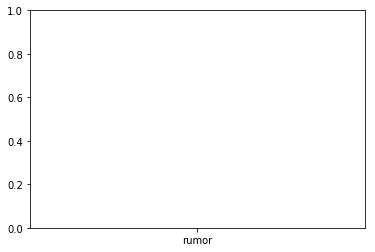

In [44]:
# plot distribution of the 'types' of articles

# data['type']=='fake'.count()
# plt.hist('type', data = data)

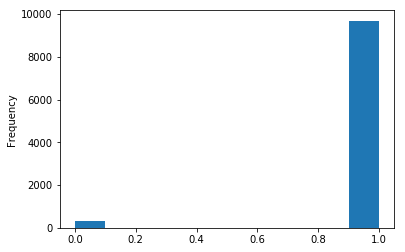

In [46]:
# change "reliable", "nan", and 'unkown' to 0
# change "rumor","hate","unreliable", etc. to 1

data.loc[data['type'] == 'reliable', 'type'] = 0

data.loc[data['type'] == 'rumor', 'type'] = 1
data.loc[data['type'] == 'hate', 'type'] = 1
data.loc[data['type'] == 'unreliable', 'type'] = 1
data.loc[data['type'] == 'conspiracy', 'type'] = 1
data.loc[data['type'] == 'clickbait', 'type'] = 1
data.loc[data['type'] == 'satire', 'type'] = 1
data.loc[data['type'] == 'fake', 'type'] = 1
data.loc[data['type'] == 'bias', 'type'] = 1
data.loc[data['type'] == 'political', 'type'] = 1
data.loc[data['type'] == 'junksci', 'type'] = 1

data.loc[data['type'] == 'nan', 'type'] = 0
data.loc[data['type'] == 'unknown', 'type'] = 0

# plot the distribution, as can be seen it is heavily skewed to fake news
data['type'].plot.hist()


In [47]:
# examine article lengths

# data['content']

0       Life is an illusion, at least on a quantum lev...
1       Unfortunately, he hasn’t yet attacked her for ...
2       The Los Angeles Police Department has been den...
3       The White House has decided to quietly withdra...
4       “The time has come to cut off the tongues of t...
5       The Central American nation and six other stat...
6       UN-Backed Police Massacred Haitians With Impun...
7       It should have come as no surprise that the sa...
8       “When the police finally left the campus, arou...
9       Zambia Must Clarify Whether It Will Host Israe...
10      \n\n\n\n\n\n\n\nRev Dr. Childress is available...
11      \n\nSpeaking Engagement Request\n\n\n\nContact...
12      "…I have set before you life and death, blessi...
13      Why We Oppose Planned Parent Hood ( The follow...
14      The website from which you got to this page is...
15      For as long as he can remember, Malcolm Turnbu...
16      For as long as he can remember, Malcolm Turnbu...
17      Most p

In [48]:
# print some examples of the articles
print(data['content'].head())

print(len(data['content'][0]))
print(data['content'][0])

print(len(data['content'][100]))
print(data['content'][100])


0    Life is an illusion, at least on a quantum lev...
1    Unfortunately, he hasn’t yet attacked her for ...
2    The Los Angeles Police Department has been den...
3    The White House has decided to quietly withdra...
4    “The time has come to cut off the tongues of t...
Name: content, dtype: object
750
Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.

They finally have the means to test John Wheeler’s delayed-choice theory and concluded that the physicist was right.

In 1978, Mr Wheeler’s proposed experiment involved a moving object that was given the choice to act like a wave or a particle – the former acting as a vibration with a frequency that can distinguish it from other waves and the latter having no frequency that you can determine its position in space, unlike a wave – and at what point does it ‘decide’ to act like one or the other.

At the time, the technology was not available to conduct a strong expe

In [103]:
# test embeddings function on one of the sample texts from the FNCsubset data
embeddings = elmo(
["Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.

They finally have the means to test John Wheeler’s delayed-choice theory and concluded that the physicist was right.

In 1978, Mr Wheeler’s proposed experiment involved a moving object that was given the choice to act like a wave or a particle – the former acting as a vibration with a frequency that can distinguish it from other waves and the latter having no frequency that you can determine its position in space, unlike a wave – and at what point does it ‘decide’ to act like one or the other.

At the time, the technology was not available to conduct a strong experiment, but scientists have now been able to carry it out.]"",
signature="default",
as_dict=True)["elmo"]

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embeddings)
    
print(message_embeddings)
print(message_embeddings.shape)

# as can be seen below, EOL's need to be removed from the original text.


SyntaxError: EOL while scanning string literal (<ipython-input-103-369137307eeb>, line 2)

In [49]:
# define function to remove EOL, parse and clip texts to all be the same length

def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
#     text = replace_contraction(text)
#     text = replace_links(text, "link")
#     text = remove_numbers(text)
#     text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
#     text = text.lower()
    return text
x = np.array(data["content"].apply(cleanText))
y = np.array(data["type"])

print(y[0])
print(x[0])

1
Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.  They finally have the means to test John Wheeler’s delayed-choice theory and concluded that the physicist was right.  In 1978, Mr Wheeler’s proposed experiment involved a moving object that was given the choice to act like a wave or a particle – the former acting as a vibration with a frequency that can distinguish it from other waves and the latter having no frequency that you can determine its position in space, unlike a wave – and at what point does it ‘decide’ to act like one or the other.  At the time, the technology was not available to conduct a strong experiment, but scientists have now been able to carry it out.


In [105]:
embeddings = elmo(
["Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.  They finally have the means to test John Wheeler’s delayed-choice theory and concluded that the physicist was right.  In 1978, Mr Wheeler’s proposed experiment involved a moving object that was given the choice to act like a wave or a particle – the former acting as a vibration with a frequency that can distinguish it from other waves and the latter having no frequency that you can determine its position in space, unlike a wave – and at what point does it ‘decide’ to act like one or the other.  At the time, the technology was not available to conduct a strong experiment, but scientists have now been able to carry it out."],
signature="default",
as_dict=True)["elmo"]

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embeddings)
    
print(message_embeddings)
print(message_embeddings.shape)

[[[-0.08702672 -0.27838883 -0.34713882 ...  0.17797771  0.5181087
   -0.07268949]
  [ 0.08745944 -0.01249989 -0.11062823 ... -0.18683037  0.9407729
    0.43985346]
  [-0.35278887  0.32002035  0.05191877 ... -0.00114899  0.10714093
    0.23674512]
  ...
  [ 0.39828107  0.13741685 -0.14582449 ...  0.39320666 -0.00747534
   -0.16896324]
  [ 0.10640743 -0.22615458  0.3454427  ...  0.6071621  -0.05122613
   -0.20663737]
  [-0.51336366  0.65279734 -0.5044402  ... -0.5662091   0.01218332
    0.37135452]]]
(1, 136, 1024)


In [66]:
# split data into train and test

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

train_data = train[['content','type']].copy()
test_data = test[['content','type']].copy()

print(len(train_data))
print(len(test_data))
print(train_data['type'].head(10))
print(train_data['content'][0])

8044
1956
0     1
1     1
2     1
4     1
5     1
6     1
7     1
8     1
10    1
11    1
Name: type, dtype: int64
Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.

They finally have the means to test John Wheeler’s delayed-choice theory and concluded that the physicist was right.

In 1978, Mr Wheeler’s proposed experiment involved a moving object that was given the choice to act like a wave or a particle – the former acting as a vibration with a frequency that can distinguish it from other waves and the latter having no frequency that you can determine its position in space, unlike a wave – and at what point does it ‘decide’ to act like one or the other.

At the time, the technology was not available to conduct a strong experiment, but scientists have now been able to carry it out.


In [69]:
# remove EOL
x_train = np.array(train_data["content"].apply(cleanText))
y_train = np.array(train_data["type"])

x_test = np.array(train_data["content"].apply(cleanText))
y_test = np.array(train_data["type"])
    
print(x_train[0])

Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.  They finally have the means to test John Wheeler’s delayed-choice theory and concluded that the physicist was right.  In 1978, Mr Wheeler’s proposed experiment involved a moving object that was given the choice to act like a wave or a particle – the former acting as a vibration with a frequency that can distinguish it from other waves and the latter having no frequency that you can determine its position in space, unlike a wave – and at what point does it ‘decide’ to act like one or the other.  At the time, the technology was not available to conduct a strong experiment, but scientists have now been able to carry it out.


In [71]:
# preprocess data to standardize lengths

x_train = keras.preprocessing.sequence.pad_sequences(x_train, value= "PAD", dtype = 'str', padding= 'post', truncating = 'post', maxlen=500)

x_test = keras.preprocessing.sequence.pad_sequences(x_test, value= "PAD", dtype = 'str', padding= 'post', truncating = 'post', maxlen=500)


TypeError: len() of unsized object

In [7]:
# df = pd.read_csv("sentences.csv",encoding="latin")
# df = df[df["sentiment"]!="Neutral"]
# df.loc[df["sentiment"]=='Negative',"sentiment"]=0
# df.loc[df["sentiment"]=='Positive',"sentiment"]=1

FileNotFoundError: [Errno 2] File b'sentences.csv' does not exist: b'sentences.csv'

In [ ]:
# import re
# def cleanText(text):
#     text = text.strip().replace("\n", " ").replace("\r", " ")
#     text = replace_contraction(text)
#     text = replace_links(text, "link")
#     text = remove_numbers(text)
#     text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
#     text = text.lower()
#     return text
# X = np.array(df["text"].apply(cleanText))
# y = np.array(df["sentiment"])

In [ ]:
# embed = hub.Module("module/module_elmo2")
# def ELMoEmbedding(x):
#     return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [ ]:
# def build_model(): 
#     input_text = Input(shape=(1,), dtype="string")
#     embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
#     dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
#     pred = Dense(1, activation='sigmoid')(dense)
#     model = Model(inputs=[input_text], outputs=pred)
#     model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     return model
# model_elmo = build_model()

In [ ]:
# with tf.Session() as session:
#     K.set_session(session)
#     session.run(tf.global_variables_initializer())  
#     session.run(tf.tables_initializer())
#     history = model_elmo.fit(X, y, epochs=5, batch_size=256, validation_split = 0.2)
#     model_elmo.save_weights('./model_elmo_weights.h5')